In [1]:
import time
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from compositional_metarl.task import MultiArmedBandit, CompositionalBandit
from compositional_metarl.model import QDNDLSTM as Agent
from compositional_metarl.utils import compute_stats, to_sqnp
from compositional_metarl.model.DND import compute_similarities
from compositional_metarl.model.utils import get_reward, compute_returns, compute_a2c_loss, get_reward_mab, run_agent_inference, one_hot_embedding
import matplotlib as mpl
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import torch.nn.functional as F
from compositional_metarl.trainers import Trainer, evaluate, CompositionTrainer

sns.set(style='white', context='talk', palette='colorblind')
seed_val = 0 
torch.manual_seed(seed_val)
np.random.seed(seed_val)
torch.cuda.manual_seed(seed_val)

In [2]:
'''init task'''

start_arm = 0
end_arm = 7
ctx_dim = 2
n_arms = (end_arm - start_arm) + 1
n_rounds = 100
n_trials = 20
normalize_rewards = True
noise_per_arm = False
RULES = {'add': torch.tensor([-1.]), 'chngpnt': torch.tensor([1.])}
CUES =  {'linpos': torch.tensor([1.0, 0.0, 1.0]), 'linneg': torch.tensor([1.0, 0., 0.]),
         'perodd': torch.tensor([0.0, 1.0, 0.]),  'pereven': torch.tensor([0.0, 1.0, 1.])}
AOI = { # linpos
       'linpos_linneg_add': 4,  
       'linpos_linneg_chngpnt': 4,  
       'linpos_perodd_add': 7,  
       'linpos_perodd_chngpnt': 7, 
       'linpos_pereven_add': 6,
       'linpos_pereven_chngpnt': 6,
       'linpos_linpos_add': 7,  
       'linpos_linpos_chngpnt': 7, 
       # linneg
       'linneg_linpos_add': 4,
       'linneg_linpos_chngpnt': 0,
       'linneg_perodd_add': 1,
       'linneg_perodd_chngpnt': 0,
       'linneg_pereven_add': 0,
       'linneg_pereven_chngpnt': 0,
       'linneg_linneg_add': 0,  
       'linneg_linneg_chngpnt': 0, 
       # perodd
       'perodd_linneg_add': 1,
       'perodd_linneg_chngpnt': 1,
       'perodd_linpos_add': 7,
       'perodd_linpos_chngpnt': 7,
       'perodd_pereven_add': 4,
       'perodd_pereven_chngpnt': 1,
       'perodd_perodd_add': 1,
       'perodd_perodd_chngpnt': 3,
       # pereven
       'pereven_linneg_add': 0,
       'pereven_linneg_chngpnt': 0,
       'pereven_perodd_add': 4,
       'pereven_perodd_chngpnt': 0,
       'pereven_linpos_add': 6,
       'pereven_linpos_chngpnt': 7,
       'pereven_pereven_add': 6,
       'pereven_pereven_chngpnt': 6}

n_cues = len(CUES)

In [3]:
bandit = MultiArmedBandit(cues=CUES, start_arm=start_arm, end_arm=end_arm, ctx_dim=ctx_dim, num_rounds=n_rounds, 
                          normalize=normalize_rewards, noise_per_arm=noise_per_arm, best_arms=AOI)
task = CompositionalBandit(bandit, rules=RULES, num_rounds=n_rounds)

In [50]:
CUES =  {'linpos': [1.0, 0.0, 1.], 'linneg': [1.0, 0., 0.],
         'perodd': [0.0, 1.0, 0.],  'pereven': [0.0, 1.0, 1.]}
keys = np.asarray(list(CUES.values()))

In [4]:
'''init model'''

# DNDLSTM params
dim_hidden = 64
inp_dim = None
ctx_dim = 7
inputs = 'context_action_reward'
dim_output = n_arms
estimate_Qvals = True
dict_len = 1000
kernel = 'l2' # 'l1' or 'l2'
dnd_policy = '1NN' # 'softmax' or '1NN'
unique_keys = False
exclude_key = True

In [5]:
agent = Agent(dim_hidden, dim_output, dict_len, input_dim=inp_dim, ctx_dim=ctx_dim, inputs=inputs, kernel=kernel, dnd_policy=dnd_policy, unique_keys=unique_keys, q_est=estimate_Qvals)

In [6]:
'''init trainer'''

n_epochs = 10
learning_rate = 5e-4 #1e-3 #5e-4 
gamma = 0.6 # 0.8
simulate_annealing = False
beta = 1. # weight for entropy loss
normalize_return = True
early_stopping = False
infer_composition = False
validation = 'LOCO'# or 'LOSO' [leave one combination or structure]

In [7]:
trainer = CompositionTrainer(agent, task, early_stopping=early_stopping, seed=seed_val, lr=learning_rate, n_trials=n_trials, beta=beta, 
                  gamma=gamma, normalize_return=normalize_return, simulate_annealing=simulate_annealing, infer_composition=infer_composition, n_epochs=n_epochs, validation=validation)

In [8]:
'''train model'''
out, avg_train_loss, avg_cum_rewards, _ = trainer.train()

Epoch 1 / 10| return = 0.02 | loss: val = 0.20, pol = -0.06, entropy = 1.03 | time = 34.12
Epoch 2 / 10| return = 0.02 | loss: val = 0.20, pol = -0.06, entropy = 1.04 | time = 33.36
Epoch 3 / 10| return = 0.02 | loss: val = 0.20, pol = -0.06, entropy = 1.04 | time = 33.20
Epoch 4 / 10| return = 0.02 | loss: val = 0.20, pol = -0.08, entropy = 1.03 | time = 33.09
Epoch 5 / 10| return = 0.02 | loss: val = 0.20, pol = -0.08, entropy = 1.03 | time = 33.28
Epoch 6 / 10| return = 0.02 | loss: val = 0.20, pol = -0.06, entropy = 1.03 | time = 32.86
Epoch 7 / 10| return = 0.02 | loss: val = 0.21, pol = -0.07, entropy = 1.03 | time = 33.04
Epoch 8 / 10| return = 0.02 | loss: val = 0.20, pol = -0.09, entropy = 1.02 | time = 32.97
Epoch 9 / 10| return = 0.02 | loss: val = 0.20, pol = -0.10, entropy = 1.02 | time = 32.04
Epoch 10 / 10| return = 0.02 | loss: val = 0.20, pol = -0.09, entropy = 1.03 | time = 33.19


In [9]:
n_epochs = trainer.current_epoch + 1

## save model

## figures

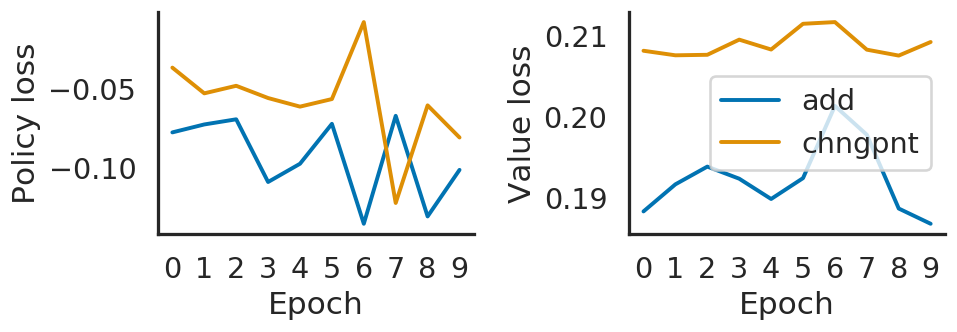

In [36]:
'''loss functions'''

f, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=125)
axes[0].plot(trainer.log_loss_policy.mean(2)[:n_epochs])
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[0].set_ylabel('Policy loss')
axes[0].set_xlabel('Epoch')

axes[1].plot(trainer.log_loss_value.mean(2)[:n_epochs])
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].set_ylabel('Value loss')
axes[1].set_xlabel('Epoch')

plt.legend(RULES)
sns.despine()
f.tight_layout()

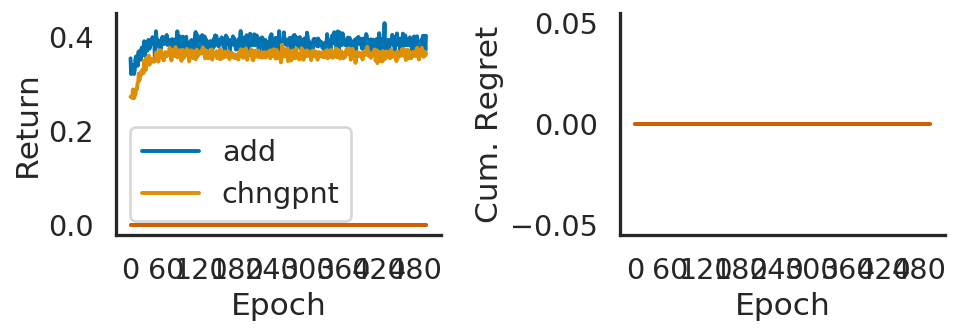

In [13]:
'''learning curves'''

f, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=125)
axes[0].plot(trainer.log_cum_return.mean(2)[:n_epochs])
axes[0].set_ylabel('Return')
axes[0].set_xlabel('Epoch')
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
# axes[0].plot(np.repeat(log_Y[:, 0, :, 7].mean(1).mean(), n_epochs), '_k')

# axes[1].plot(log_regret.mean(3).mean(2)) # mean regreat across trials and rounds
axes[1].plot(trainer.log_regret.cumsum(3).max(3).mean(2)[:n_epochs])
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].set_ylabel('Cum. Regret')
axes[1].set_xlabel('Epoch')

axes[0].legend(rules)
sns.despine()
f.tight_layout()

In [23]:
trainer.log_Y_hat.shape

(10, 2, 100, 20)

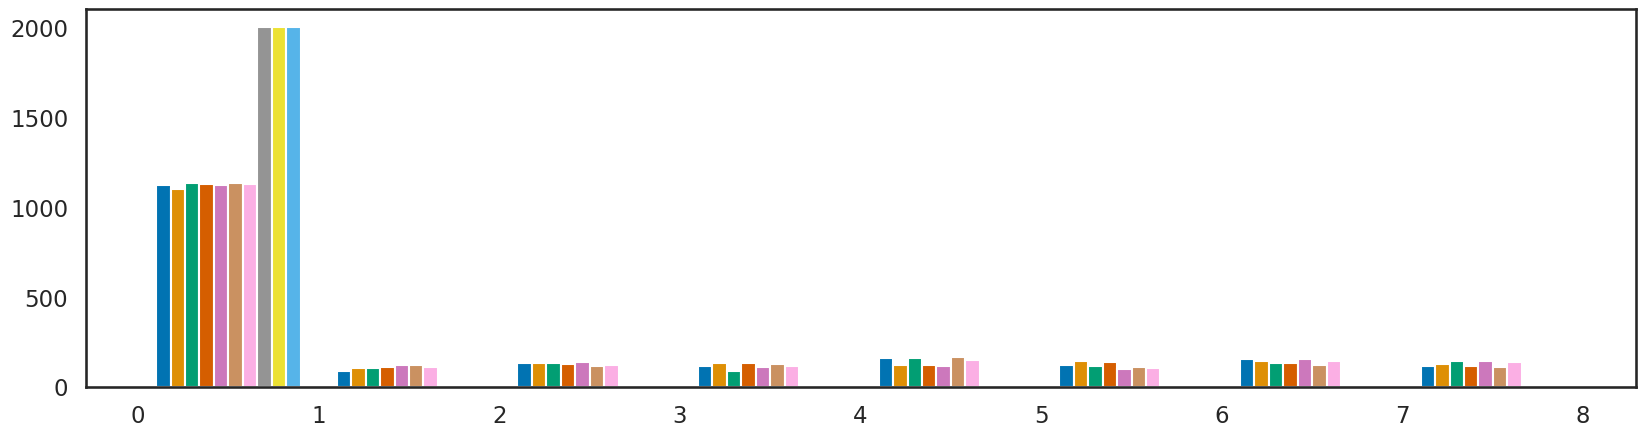

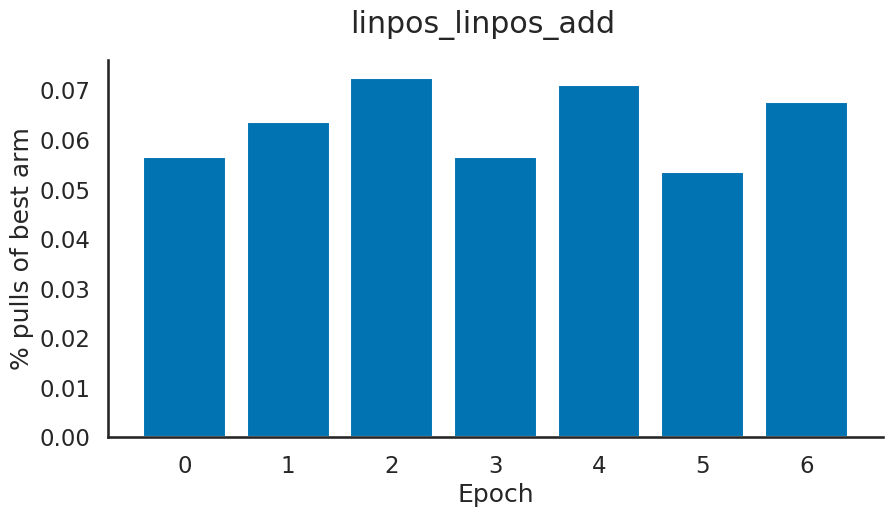

In [29]:
''' action distribution across epochs'''

rule = 'add'

rule_id = None
for idx, key in enumerate(RULES.keys()):
    if key == rule:
        rule_id = idx
f, ax = plt.subplots(1, 1, figsize=(20, 5), dpi=100)
bins = np.linspace(start_arm, end_arm+1, n_arms+1)
pulls_per_arm = plt.hist(trainer.log_Y_hat[:, rule_id, :, :].reshape(10, n_rounds*n_trials).T, bins=bins)

#ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
#ax[0].set(xlabel='Arm', ylabel='No. of pulls per arm')
#ax[0].set_xlim([start_arm, end_arm+1])

f, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
ax.bar(range(n_epochs), np.vstack(pulls_per_arm[0])[:,AOI[cue]][:n_epochs]/(n_rounds*n_trials))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set(ylabel='% pulls of best arm',
       xlabel='Epoch')
f.suptitle(cue)
sns.despine()
plt.savefig(cue)

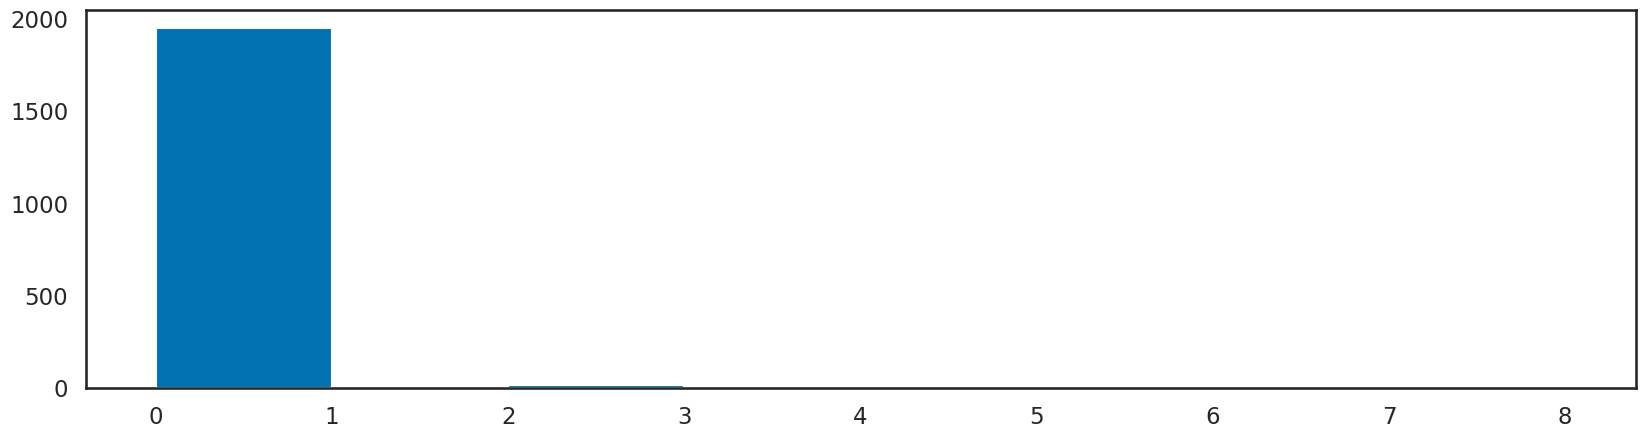

In [35]:
''' action distribution across epochs'''

rule = 'linpos_linpos_add'
epoch = 10

rule_id = None
for idx, key in enumerate(list(AOI.keys())):
    if key == rule:
        rule_id = idx
f, ax = plt.subplots(1, 1, figsize=(20, 5), dpi=100)
bins = np.linspace(start_arm, end_arm+1, n_arms+1)
pulls_per_arm = plt.hist(trainer.log_Y_hat[epoch-1, rule_id, :, :].reshape(1, n_rounds*n_trials).T, bins=bins)

#ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
#ax[0].set(xlabel='Arm', ylabel='No. of pulls per arm')
#ax[0].set_xlim([start_arm, end_arm+1])

# f, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
# ax.bar(range(n_epochs), np.vstack(pulls_per_arm[0])[:,AOI[rule_id]][:n_epochs]/(n_rounds*n_trials))
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# ax.set(ylabel='% pulls of best arm',
#        xlabel='Epoch')
# f.suptitle(cue)
# sns.despine()
# plt.savefig(cue)

0

In [30]:
# CUES_EVAL =  {'linear': torch.tensor([1.0, 0.0,0.]), 'periodic': torch.tensor([0.0, 1.0, 1.]), 'linperiodic': torch.tensor([1.0, 1.0, 0.])}
# CUES_EVAL =  {'linpos': torch.tensor([1.0, 1.0]), 'linneg': torch.tensor([1.0, 0.]), 'perodd': torch.tensor([0.0, 0.0]), 'pereven': torch.tensor([0.0, 1.0])}
# task = MultiArmedBandit(cues=CUES_EVAL, start_arm=start_arm, end_arm=end_arm, ctx_dim=ctx_dim, num_rounds=n_rounds, normalize=normalize_rewards)
# CUES_EVAL = CUES

CUES_EVAL =  {'linpos': torch.tensor([1.0, 0.0, 1.0]), 'linneg': torch.tensor([1.0, 0., 0.]), 'perodd': torch.tensor([0.0, 1.0, 0.]), 'pereven': torch.tensor([0.0, 1.0, 1.])}

In [33]:
''' model evaluation for different cues'''
rule = 'add'  #rules[1]
n_runs = 10

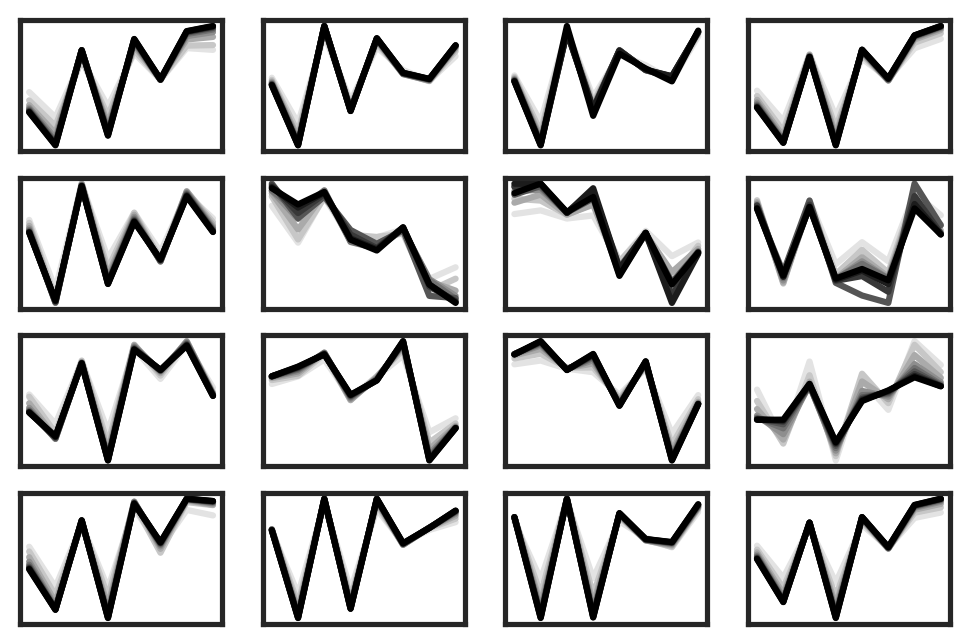

In [35]:
f, ax = plt.subplots(4, 4, figsize=(6, 4), dpi=200)
arms = ['A', 'S', 'D', 'F', 'J', 'K', 'L', ';'] 

# set up the color scheme
c = np.arange(n_runs) + 1
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.gray_r)
cmap.set_array([])


for ix, cue1 in enumerate(CUES_EVAL):
    
    for iy, cue2 in enumerate(CUES_EVAL):
        
        cue = '_'.join(list([cue1, cue2, rule]))
        X, Y = task.sample(end_rnd=1, cue=cue)
        #X[0][6] = X[0][6]*10
        agent.eval()
        agent.turn_off_encoding()
        #agent.turn_off_retrieval()
        
        # set init states
        h_t, c_t = agent.get_init_states()
        h_t, c_t = torch.zeros_like(h_t), torch.zeros_like(c_t) 
        a_t = torch.randint(high=dim_output,size=(1,))
        r_t = Y[0][a_t] 
        actions, dist, values, temps = [], [], [], []
        # run model
        for t in range(n_runs):
            h_t1 = h_t
            c_t1 = c_t
            #X[0][6] = X[0][6]*100
            x_t = X # CUES_EVAL[cue]   # torch.tensor([-100., -100.]) # CUES_EVAL[cue]  
            if inputs == 'context_action_reward':
                one_hot_a_t = one_hot_embedding(a_t, n_arms)
                x_t = torch.cat((x_t.reshape(-1).type(torch.FloatTensor), one_hot_a_t.reshape(-1).type(torch.FloatTensor), r_t.reshape(-1).type(torch.FloatTensor)), dim=0)
            output_t, c = agent(x_t, h_t, c_t)
            a_t, prob_a_t, v_t, h_t, c_t = output_t
            f_t, i_t, o_t, rg_t, m_t, q_t, pa_t = c
            a_t = torch.argmax(q_t)

            ax[ix][iy].plot(arms, q_t.detach().numpy().T, c=cmap.to_rgba(t + 1))
            ax[ix][iy].axes.xaxis.set_visible(False)
            ax[ix][iy].axes.yaxis.set_visible(False)